## Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel

### O que temos disponível, inspirações e créditos
As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
Os preços são dados em reais (R$)
Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais
- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas

In [112]:
import pandas as pd
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [54]:
dados_conexao = (
    "Driver={SQL Server};"
    "Server=Erick;"
    "Database=AirBnb_Rio;"
)

conexao = pyodbc.connect(dados_conexao)
print("Conexão Bem Sucedida")

cursor = conexao.cursor()

Conexão Bem Sucedida


In [55]:
pyodbc.drivers()

['SQL Server',
 'SQLite3 ODBC Driver',
 'SQLite ODBC Driver',
 'SQLite ODBC (UTF-8) Driver',
 'SQL Server Native Client RDA 11.0',
 'ODBC Driver 17 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)']

In [56]:
base = pd.read_sql('SELECT * FROM AirBnbPY', conexao)

C:\Users\erick\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [57]:
display(base)

Superhost? Total de Apartamentos             Latitude  \
0               f                   1.0  -22.958775235093217   
1               f                   1.0   -22.96230572680881   
2               f                  23.0    -22.9665013726163   
3               f                   5.0   -22.92136311069515   
4               f                   4.0   -22.96444134967984   
...           ...                   ...                  ...   
383778          f                   1.0  -22.912801455221416   
383779          f                   1.0   -22.96435303521498   
383780          f                   1.0   -22.96359342361465   
383781          f                   1.0   -22.94109771619969   
383782          f                   2.0  -22.917509306678586   

                  Longitude Tipo da Propriedade   Tipo do Quarto  \
0        -43.20164158773811           Apartment  Entire home/apt   
1        -43.16942979687084           Apartment     Private room   
2        -43.17590422809456           Apartment  Entire home/apt   
3        -43.18333694454349               House     Private room   
4        -43.19284983076954           Apartment  Entire home/apt   
...                     ...                 ...              ...   
383778  -43.200535519736086           Apartment  Entire home/apt   
383779   -43.17434349444402           Apartment  Entire home/apt   
383780    -43.4073288099324               Other  Entire home/apt   
383781   -43.20336363542869           Apartment     Private room   
383782   -43.25500462002842               House     Private room   

       Quantidade de Benefícios Quantidade de Banheiros Quantidade de Quartos  \
0                             1                     1.0                   1.0   
1                             4                     1.0                   1.0   
2                            10                     4.0                   4.0   
3                             2                     1.0                   1.0   
4                             3                     1.0                   1.0   
...                         ...                     ...                   ...   
383778                        6                     1.0                   2.0   
383779                        2                     1.0                   1.0   
383780                        2                     1.0                   0.0   
383781                        2                     2.0                   1.0   
383782                        1                     2.0                   1.0   

       Quantidade de Camas  ... Depósito de Segurança  \
0                      3.0  ...                  None   
1                      2.0  ...                  None   
2                      8.0  ...             $1,500.00   
3                      1.0  ...                  None   
4                      1.0  ...                  None   
...                    ...  ...                   ...   
383778                 1.0  ...            $16,562.00   
383779                 1.0  ...             $1,500.00   
383780                 1.0  ...                  None   
383781                 1.0  ...                  None   
383782                 2.0  ...                  None   

       Quantidade Máxima de Pessoas Valor por Pessoa Extra  \
0                                 1                  $0.00   
1                                 1                  $0.00   
2                                 6                 $80.00   
3                                 1                  $0.00   
4                                 1                  $0.00   
...                             ...                    ...   
383778                            1                $100.00   
383779                            2                 $70.00   
383780                            1                  $0.00   
383781                            1                  $0.00   
383782                            1                  $0.00   

       Quantidade 

### Tratar Valores Faltando
- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 100.000 valores NaN foram excluídas da análise
- Para as outras colunas, como temos muitos dados (mais de 300.000 linhas) vamos exluir as linhas que contém dados NaN

In [58]:
print(base.isnull().sum())        

Superhost?                           0
Total de Apartamentos                0
Latitude                             0
Longitude                            0
Tipo da Propriedade                  0
Tipo do Quarto                       0
Quantidade de Benefícios             0
Quantidade de Banheiros            899
Quantidade de Quartos              444
Quantidade de Camas               1658
Tipo da Cama                         0
Bônus                                0
Preço                                0
Depósito de Segurança           224845
Quantidade Máxima de Pessoas         0
Valor por Pessoa Extra               0
Quantidade Mínima de Noites          0
Quantidade Máxima de Noites          0
Quantidade de Reviews                0
Reserva Instantânea                  0
Política de Cancelamento             0
Ano                                  0
Mês                                  0
dtype: int64


In [59]:
base = base.drop('Depósito de Segurança', axis=1)

In [60]:
base = base.dropna()

### Verificar Tipos de Dados em cada coluna

In [61]:
print(base.dtypes)
print('-'*60)
print(base.iloc[0])

Superhost?                      object
Total de Apartamentos           object
Latitude                        object
Longitude                       object
Tipo da Propriedade             object
Tipo do Quarto                  object
Quantidade de Benefícios        object
Quantidade de Banheiros         object
Quantidade de Quartos           object
Quantidade de Camas             object
Tipo da Cama                    object
Bônus                           object
Preço                           object
Quantidade Máxima de Pessoas    object
Valor por Pessoa Extra          object
Quantidade Mínima de Noites     object
Quantidade Máxima de Noites     object
Quantidade de Reviews           object
Reserva Instantânea             object
Política de Cancelamento        object
Ano                             object
Mês                             object
dtype: object
------------------------------------------------------------
Superhost?                                                         

In [62]:
base['Total de Apartamentos'] = base['Total de Apartamentos'].astype(np.float32, copy = False)
base['Quantidade de Banheiros'] = base['Quantidade de Banheiros'].astype(np.float32, copy= False)
base['Quantidade de Quartos'] = base['Quantidade de Quartos'].astype(np.float32, copy= False)
base['Quantidade de Camas'] = base['Quantidade de Camas'].astype(np.float32, copy= False)
base['Quantidade de Benefícios'] = base['Quantidade de Benefícios'].astype(np.float32, copy= False)
base['Quantidade Máxima de Pessoas'] = base['Quantidade Máxima de Pessoas'].astype(np.float32, copy= False)
base['Quantidade Mínima de Noites'] = base['Quantidade Mínima de Noites'].astype(np.float32, copy= False)
base['Quantidade Máxima de Noites'] = base['Quantidade Máxima de Noites'].astype(np.float32, copy= False)
base['Quantidade de Reviews'] = base['Quantidade de Reviews'].astype(np.float32, copy= False)
base['Ano'] = base['Ano'].astype(np.float32, copy= False)
base['Mês'] = base['Mês'].astype(np.float32, copy= False)

In [63]:
base['Total de Apartamentos'] = base['Total de Apartamentos'].astype(np.int32, copy = False)
base['Quantidade de Banheiros'] = base['Quantidade de Banheiros'].astype(np.int32, copy= False)
base['Quantidade de Quartos'] = base['Quantidade de Quartos'].astype(np.int32, copy= False)
base['Quantidade de Camas'] = base['Quantidade de Camas'].astype(np.int32, copy= False)
base['Quantidade de Benefícios'] = base['Quantidade de Benefícios'].astype(np.int32, copy= False)
base['Quantidade Máxima de Pessoas'] = base['Quantidade Máxima de Pessoas'].astype(np.int32, copy= False)
base['Quantidade Mínima de Noites'] = base['Quantidade Mínima de Noites'].astype(np.int32, copy= False)
base['Quantidade Máxima de Noites'] = base['Quantidade Máxima de Noites'].astype(np.int32, copy= False)
base['Quantidade de Reviews'] = base['Quantidade de Reviews'].astype(np.int32, copy= False)
base['Ano'] = base['Ano'].astype(np.int32, copy= False)
base['Mês'] = base['Mês'].astype(np.int32, copy= False)

In [64]:
base['Latitude'] = base['Latitude'].astype(np.float32, copy= False)
base['Longitude'] = base['Longitude'].astype(np.float32, copy= False)

In [65]:
print(base.iloc[0])

Superhost?                                                                      f
Total de Apartamentos                                                           1
Latitude                                                               -22.958775
Longitude                                                              -43.201641
Tipo da Propriedade                                                     Apartment
Tipo do Quarto                                                    Entire home/apt
Quantidade de Benefícios                                                        1
Quantidade de Banheiros                                                         1
Quantidade de Quartos                                                           1
Quantidade de Camas                                                             3
Tipo da Cama                                                             Real Bed
Bônus                           "{TV,Wifi,""Air conditioning"",Kitchen,""Free ...
Preço           

In [66]:
base['Preço'] = base['Preço'].str.replace('$','')
base['Preço'] = base['Preço'].str.replace(',','')
base['Preço'] = base['Preço'].astype(np.float32, copy = False)

base['Valor por Pessoa Extra'] = base['Valor por Pessoa Extra'].str.replace('$','')
base['Valor por Pessoa Extra'] = base['Valor por Pessoa Extra'].str.replace(',','')
base['Valor por Pessoa Extra'] = base['Valor por Pessoa Extra'].astype(np.float32, copy = False)

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\510779806.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base['Preço'] = base['Preço'].str.replace('$','')
C:\Users\erick\AppData\Local\Temp\ipykernel_13080\510779806.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base['Valor por Pessoa Extra'] = base['Valor por Pessoa Extra'].str.replace('$','')


In [67]:
print(base.dtypes)

Superhost?                       object
Total de Apartamentos             int32
Latitude                        float32
Longitude                       float32
Tipo da Propriedade              object
Tipo do Quarto                   object
Quantidade de Benefícios          int32
Quantidade de Banheiros           int32
Quantidade de Quartos             int32
Quantidade de Camas               int32
Tipo da Cama                     object
Bônus                            object
Preço                           float32
Quantidade Máxima de Pessoas      int32
Valor por Pessoa Extra          float32
Quantidade Mínima de Noites       int32
Quantidade Máxima de Noites       int32
Quantidade de Reviews             int32
Reserva Instantânea              object
Política de Cancelamento         object
Ano                               int32
Mês                               int32
dtype: object


### Análise Exploratória e Tratar Outliers
- Vamos basicamente olhar feature por feature para:

1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

<Axes: >

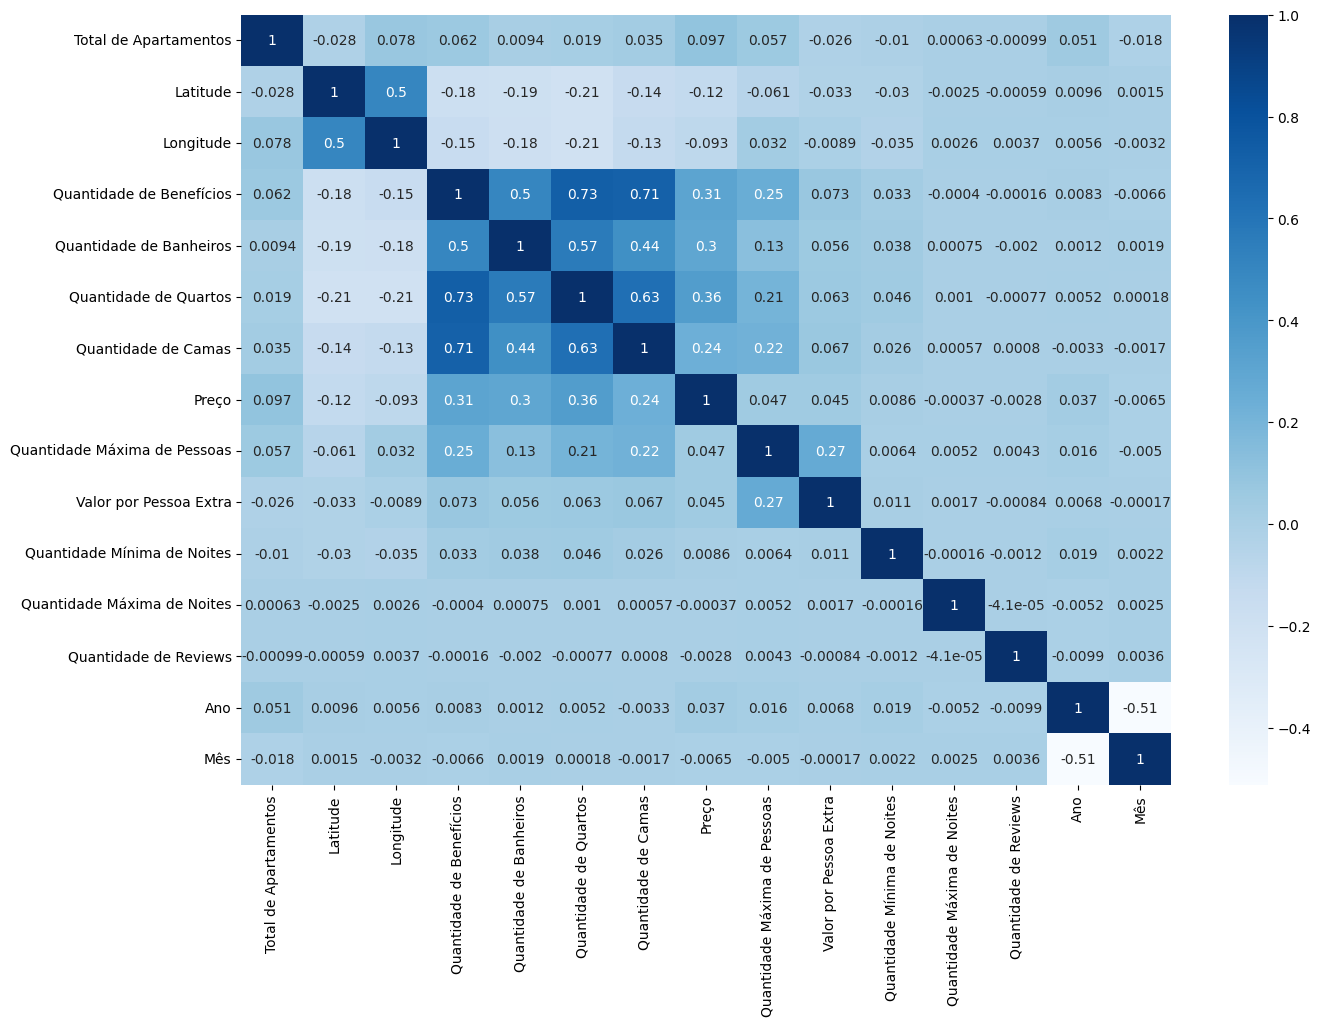

In [68]:
plt.figure(figsize=(15,10))
sns.heatmap(base.corr(), annot=True, cmap='Blues')

### Definição de funções para análise de outliers
- Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [69]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.distplot(coluna, hist=True)
    
def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

In [70]:
print(base.dtypes)

Superhost?                       object
Total de Apartamentos             int32
Latitude                        float32
Longitude                       float32
Tipo da Propriedade              object
Tipo do Quarto                   object
Quantidade de Benefícios          int32
Quantidade de Banheiros           int32
Quantidade de Quartos             int32
Quantidade de Camas               int32
Tipo da Cama                     object
Bônus                            object
Preço                           float32
Quantidade Máxima de Pessoas      int32
Valor por Pessoa Extra          float32
Quantidade Mínima de Noites       int32
Quantidade Máxima de Noites       int32
Quantidade de Reviews             int32
Reserva Instantânea              object
Política de Cancelamento         object
Ano                               int32
Mês                               int32
dtype: object


## Verificando Outliers

### Preço

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


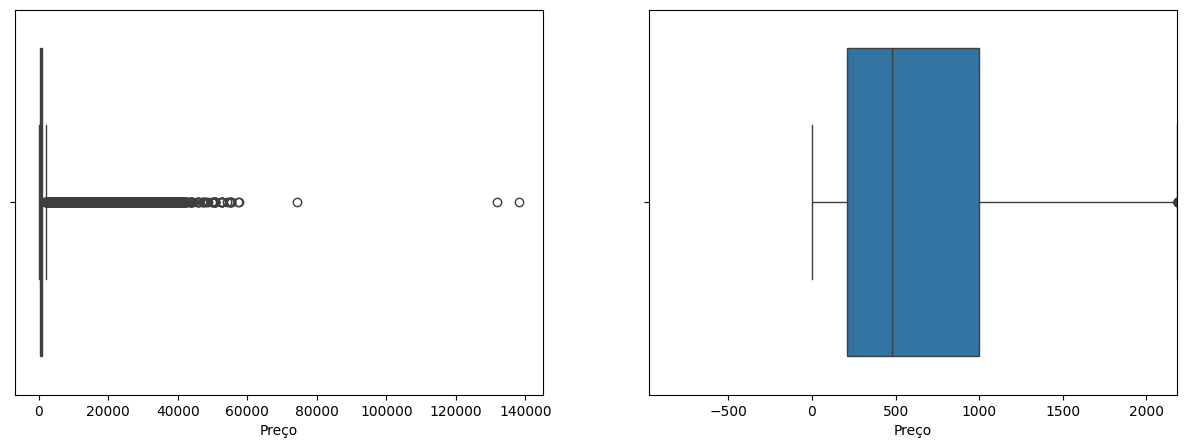

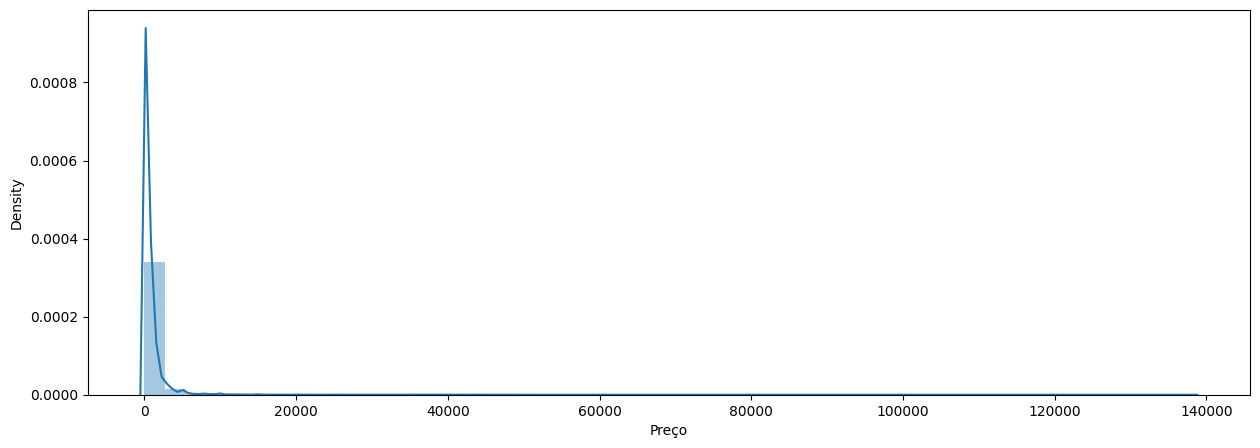

In [71]:
diagrama_caixa(base['Preço'])
histograma(base['Preço'])

### Valor por Pessoa Extra

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:18: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


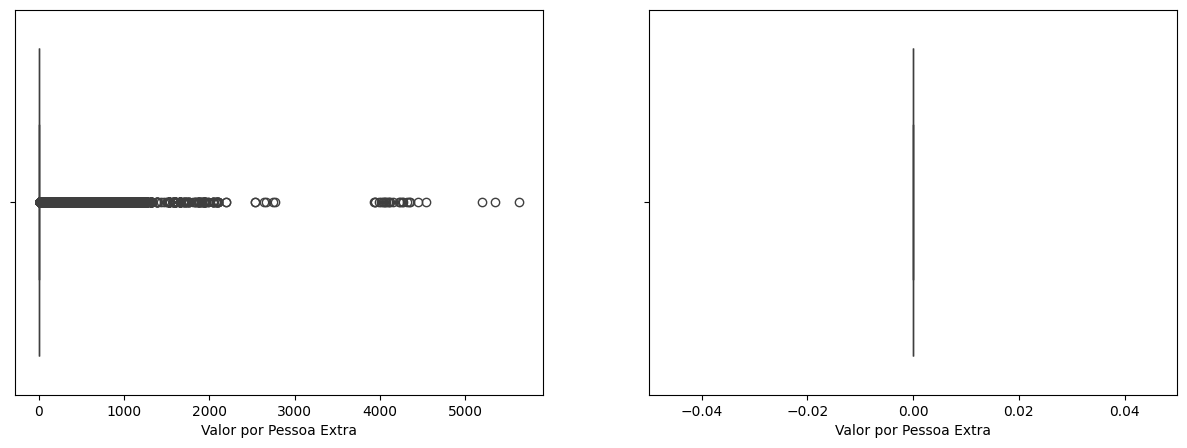

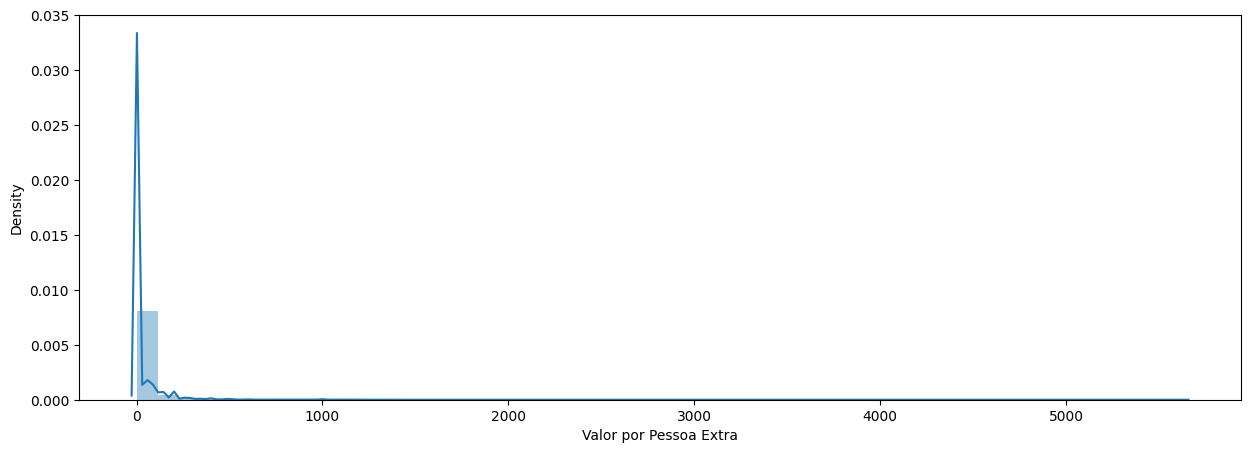

In [72]:
diagrama_caixa(base['Valor por Pessoa Extra'])
histograma(base['Valor por Pessoa Extra'])

### Total de Apartamentos

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


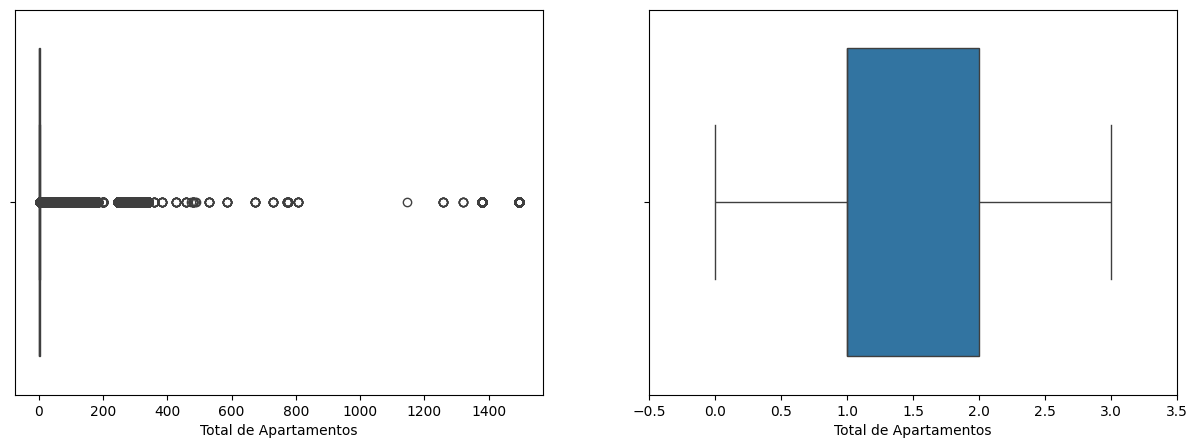

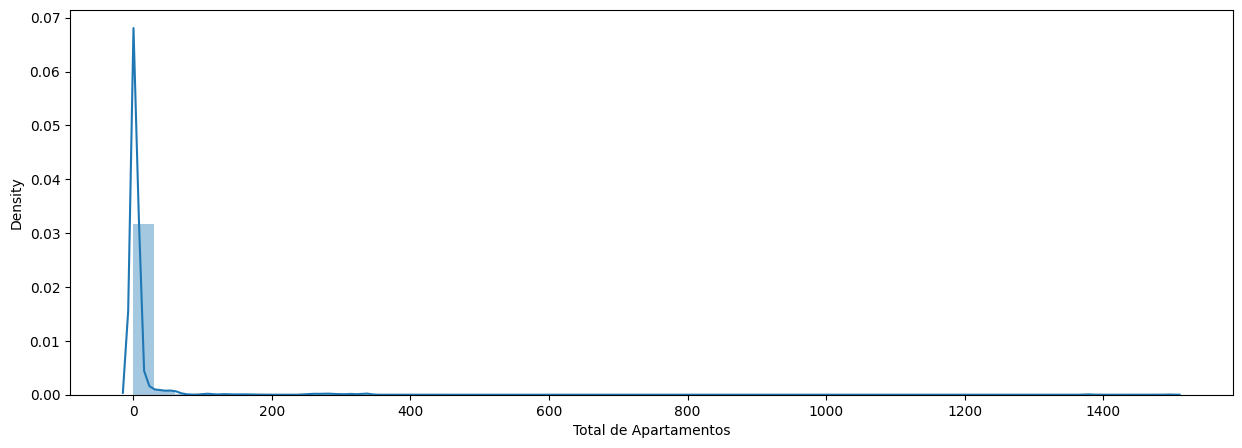

In [73]:
diagrama_caixa(base['Total de Apartamentos'])
histograma(base['Total de Apartamentos'])

### Quantidade de Benefícios

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


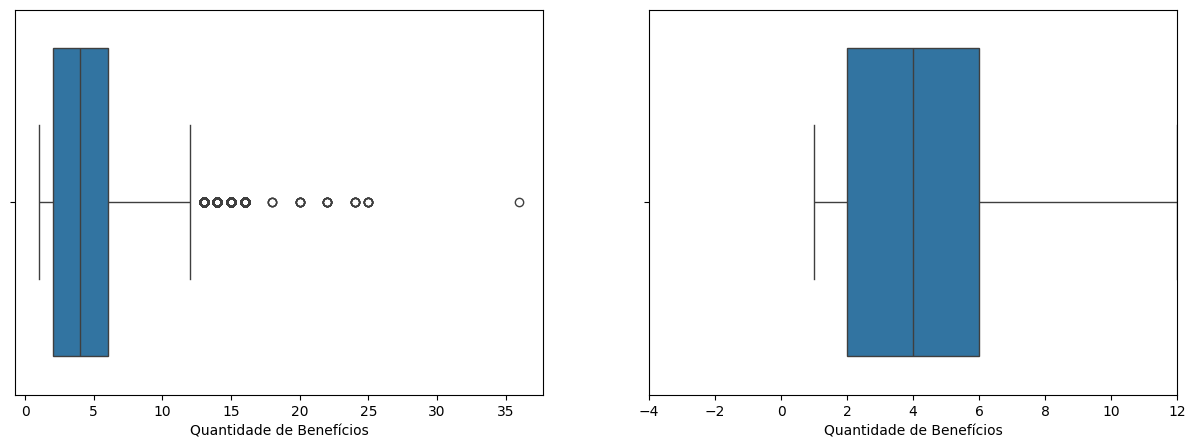

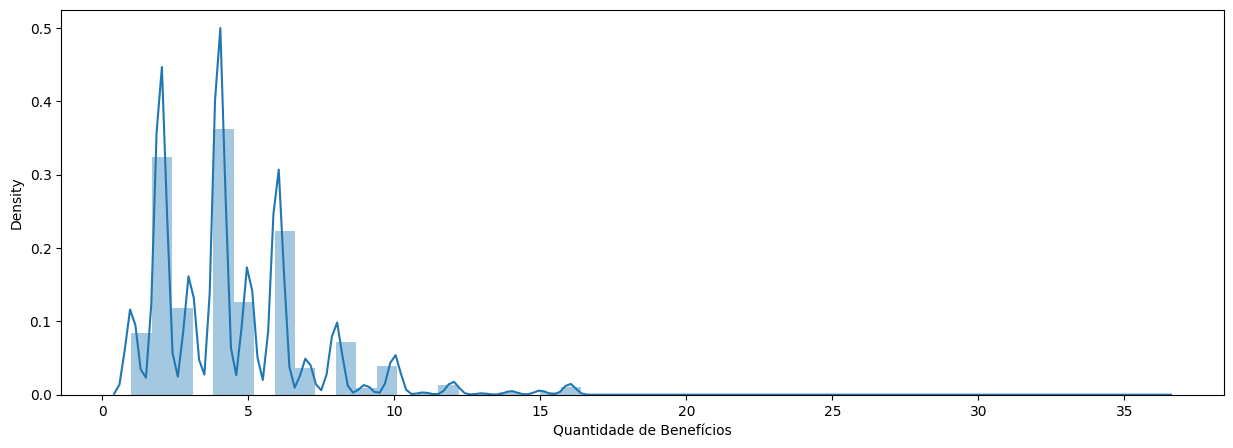

In [74]:
diagrama_caixa(base['Quantidade de Benefícios'])
histograma(base['Quantidade de Benefícios'])

### Quantidade de Banheiros

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


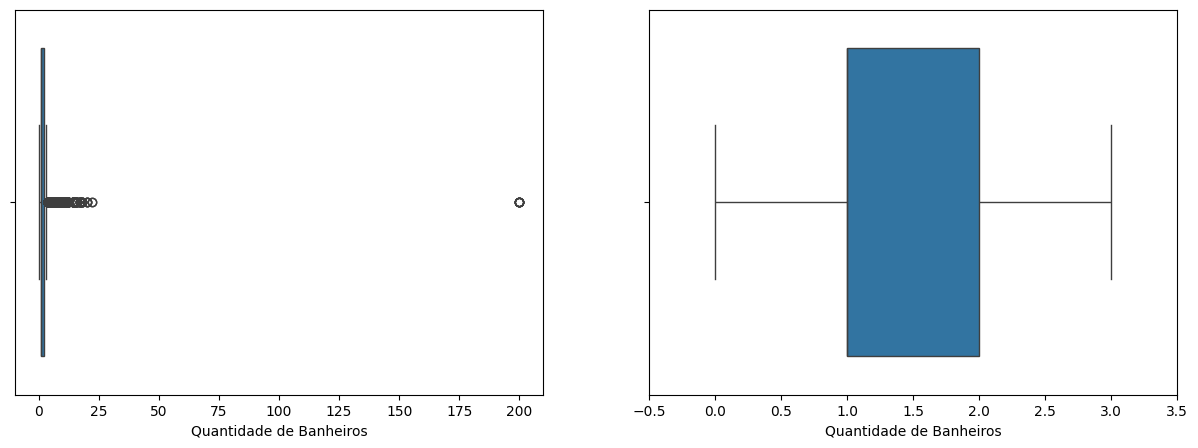

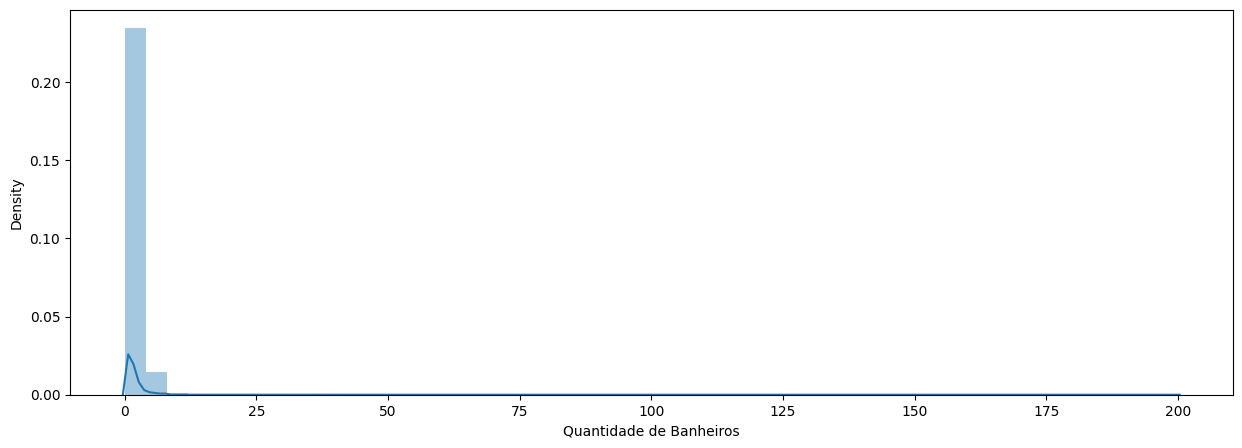

In [75]:
diagrama_caixa(base['Quantidade de Banheiros'])
histograma(base['Quantidade de Banheiros'])

### Quantidade de Quartos

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


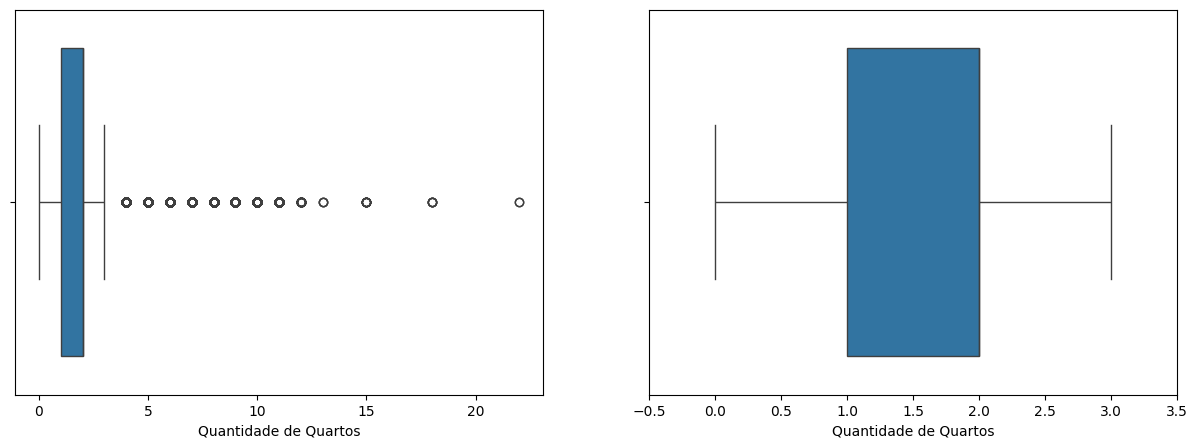

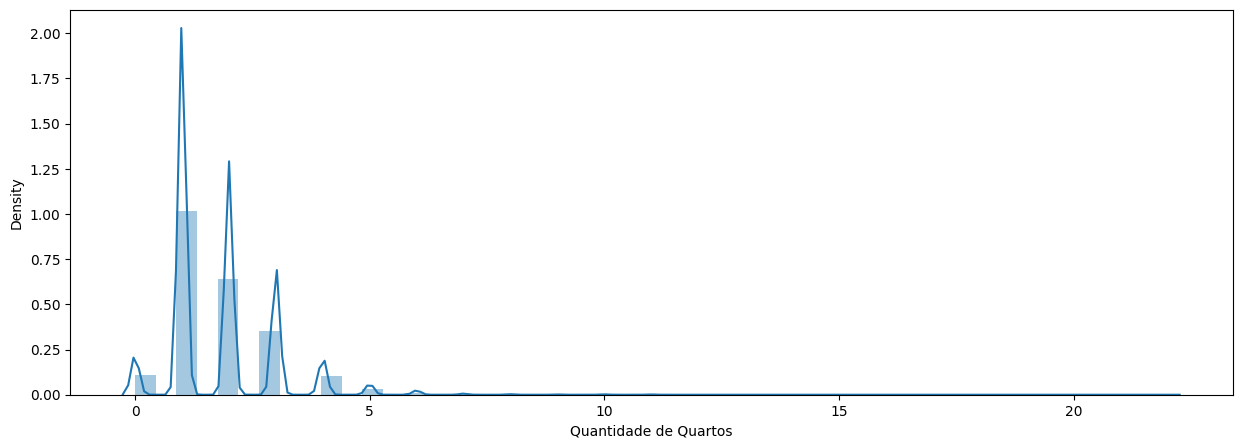

In [76]:
diagrama_caixa(base['Quantidade de Quartos'])
histograma(base['Quantidade de Quartos'])

### Quantidade de Camas

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


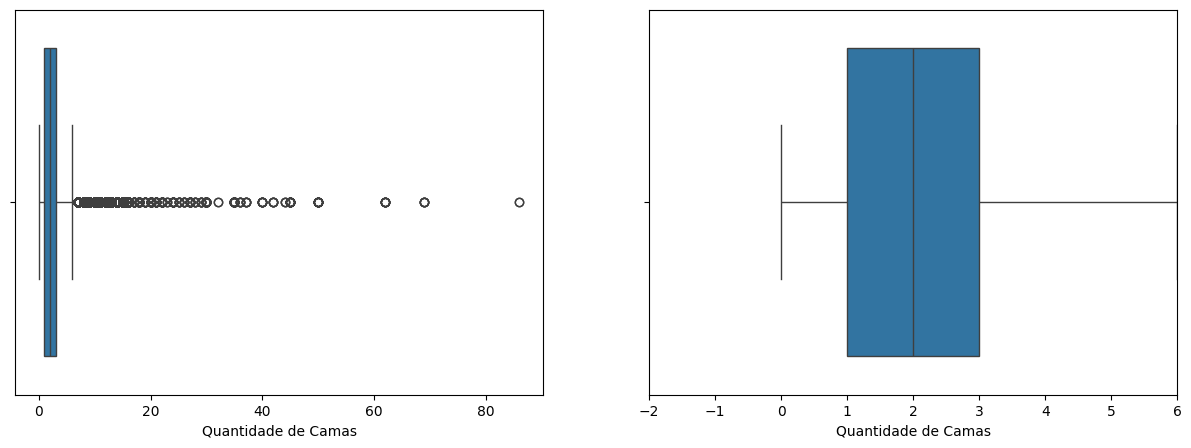

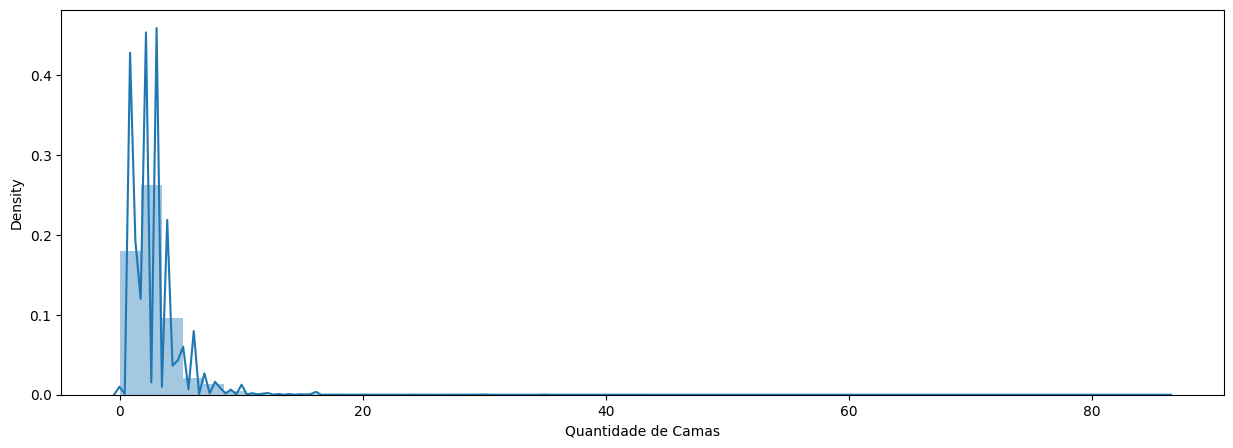

In [77]:
diagrama_caixa(base['Quantidade de Camas'])
histograma(base['Quantidade de Camas'])

### Quantidade Máxima de Pessoas

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:18: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


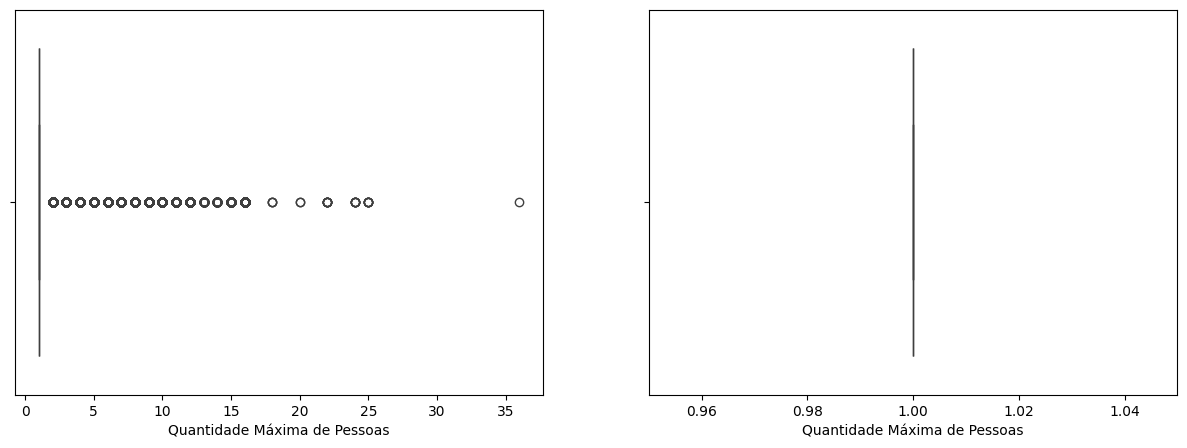

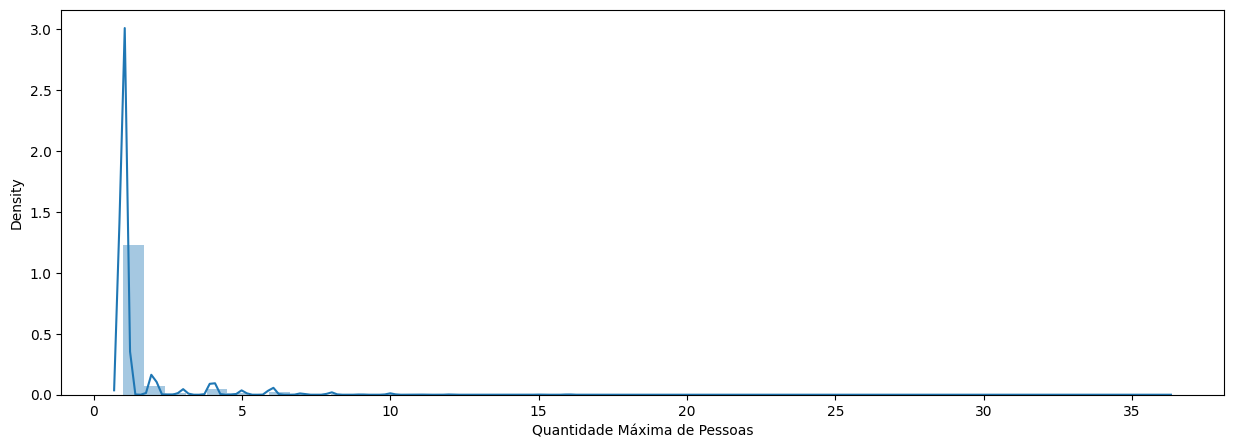

In [78]:
diagrama_caixa(base['Quantidade Máxima de Pessoas'])
histograma(base['Quantidade Máxima de Pessoas'])

### Quantidade Mínima de Noites

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


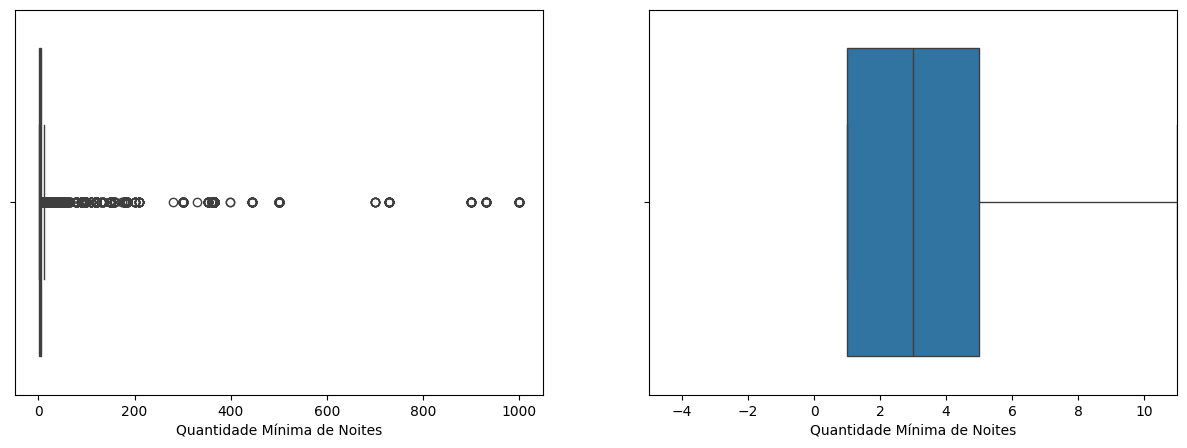

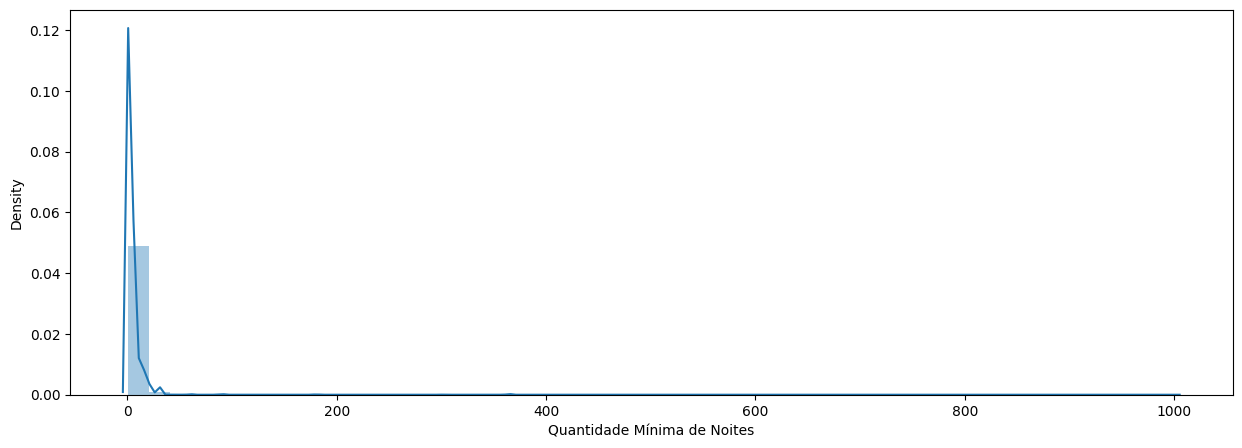

In [79]:
diagrama_caixa(base['Quantidade Mínima de Noites'])
histograma(base['Quantidade Mínima de Noites'])

### Quantidade Máxima de Noites

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


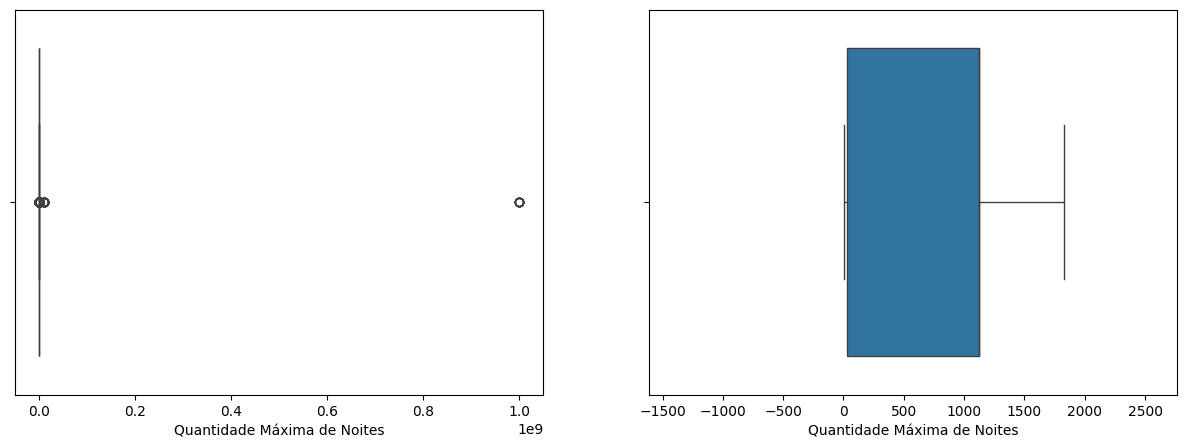

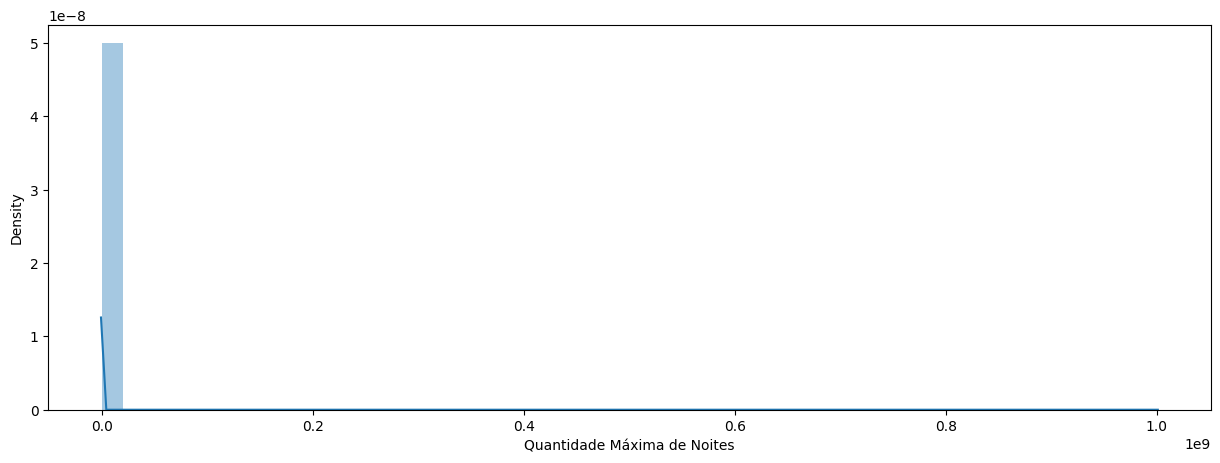

In [80]:
diagrama_caixa(base['Quantidade Máxima de Noites'])
histograma(base['Quantidade Máxima de Noites'])

### Quantidade de Reviews

C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:18: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites(coluna))
C:\Users\erick\AppData\Local\Temp\ipykernel_13080\1911417171.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(coluna, hist=True)


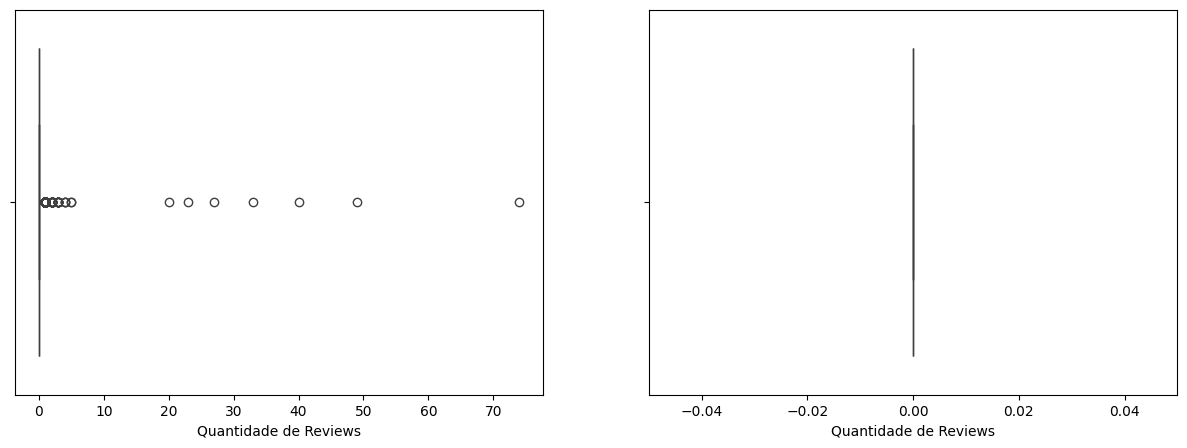

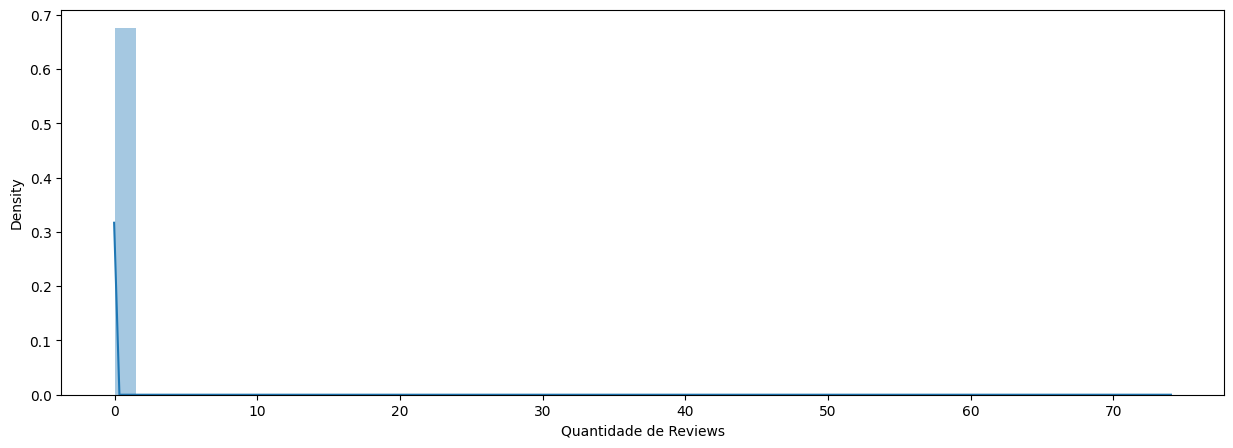

In [81]:
diagrama_caixa(base['Quantidade de Reviews'])
histograma(base['Quantidade de Reviews'])

In [82]:
base.shape

(381489, 22)

In [83]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381489 entries, 0 to 383782
Data columns (total 22 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Superhost?                    381489 non-null  object 
 1   Total de Apartamentos         381489 non-null  int32  
 2   Latitude                      381489 non-null  float32
 3   Longitude                     381489 non-null  float32
 4   Tipo da Propriedade           381489 non-null  object 
 5   Tipo do Quarto                381489 non-null  object 
 6   Quantidade de Benefícios      381489 non-null  int32  
 7   Quantidade de Banheiros       381489 non-null  int32  
 8   Quantidade de Quartos         381489 non-null  int32  
 9   Quantidade de Camas           381489 non-null  int32  
 10  Tipo da Cama                  381489 non-null  object 
 11  Bônus                         381489 non-null  object 
 12  Preço                         381489 non-nul

### Tratamento de Colunas de Valores de Texto

### Superhost?

f    369733
t     11756
Name: Superhost?, dtype: int64


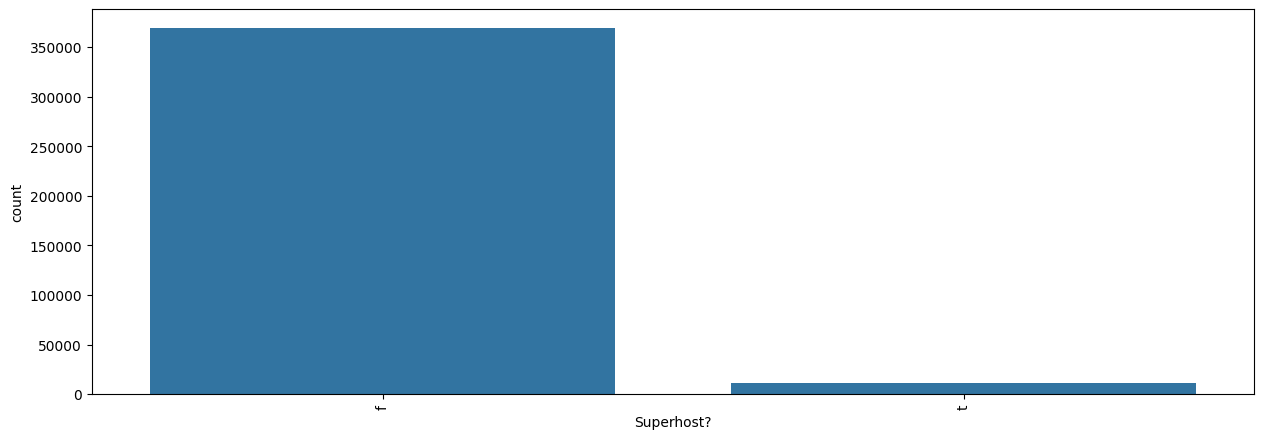

In [84]:
print(base['Superhost?'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base, x='Superhost?')
grafico.tick_params(axis='x', rotation=90)

- Temos uma diferença muito grande numéricamente entre anfitrões superhost e não superhost, no futuro podemos testar subamostragem e sobreamostragem

### Tipo da Propriedade

Apartment                 300654
House                      42884
Condominium                12604
Serviced apartment          5135
Loft                        4751
Bed and breakfast           2891
Hostel                      2540
Other                       1707
Guest suite                 1686
Villa                       1585
Guesthouse                  1092
Hotel                        681
Boutique hotel               391
Boat                         388
Earth house                  348
Aparthotel                   343
Townhouse                    316
Casa particular (Cuba)       238
Cottage                      184
Tiny house                   175
Chalet                       161
Bungalow                     128
Dorm                         104
Castle                       102
Cabin                         58
Campsite                      53
Nature lodge                  47
Resort                        37
Camper/RV                     31
Tipi                          25
Treehouse 

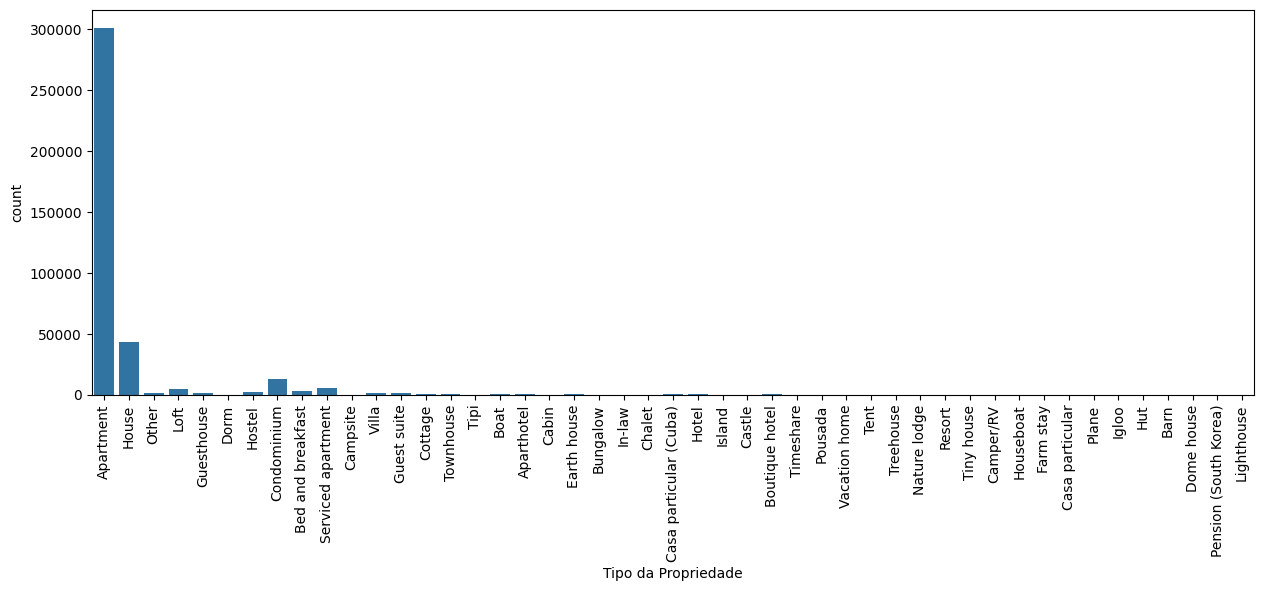

In [85]:
print(base['Tipo da Propriedade'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base, x='Tipo da Propriedade')
grafico.tick_params(axis='x', rotation=90)

- Aqui a nossa ação não é agrupar valores que são muito pequenos.

- Todos os tipos de propriedade que têm menos de 2.000 propriedades na base de dados, eu vou agrupar em um grupo chamado "outros". Acho que isso vai facilitar o nosso modelo

['Other', 'Guest suite', 'Villa', 'Guesthouse', 'Hotel', 'Boutique hotel', 'Boat', 'Earth house', 'Aparthotel', 'Townhouse', 'Casa particular (Cuba)', 'Cottage', 'Tiny house', 'Chalet', 'Bungalow', 'Dorm', 'Castle', 'Cabin', 'Campsite', 'Nature lodge', 'Resort', 'Camper/RV', 'Tipi', 'Treehouse', 'Vacation home', 'Tent', 'Houseboat', 'Island', 'Pousada', 'In-law', 'Hut', 'Barn', 'Farm stay', 'Casa particular', 'Timeshare', 'Igloo', 'Dome house', 'Pension (South Korea)', 'Plane', 'Lighthouse']


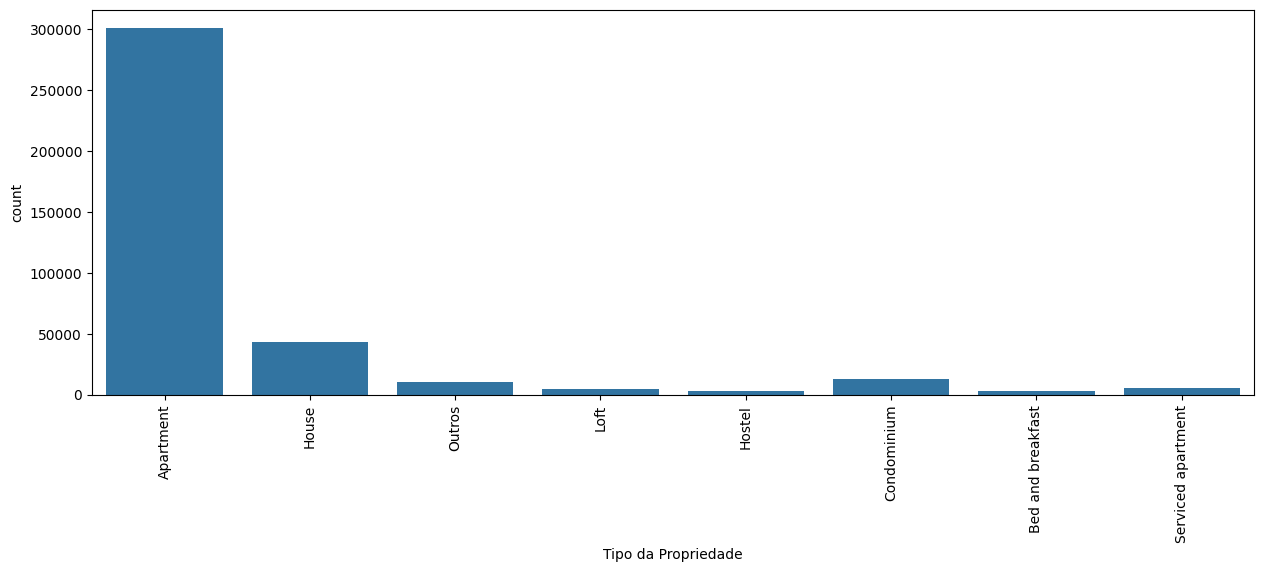

In [86]:
tabela_tipos_casa = base['Tipo da Propriedade'].value_counts()
coluna_agurupar = []
for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        coluna_agurupar.append(tipo)
print(coluna_agurupar)

In [87]:
for tipo in coluna_agurupar:
    base.loc[base['Tipo da Propriedade']==tipo, 'Tipo da Propriedade'] = 'Outros'

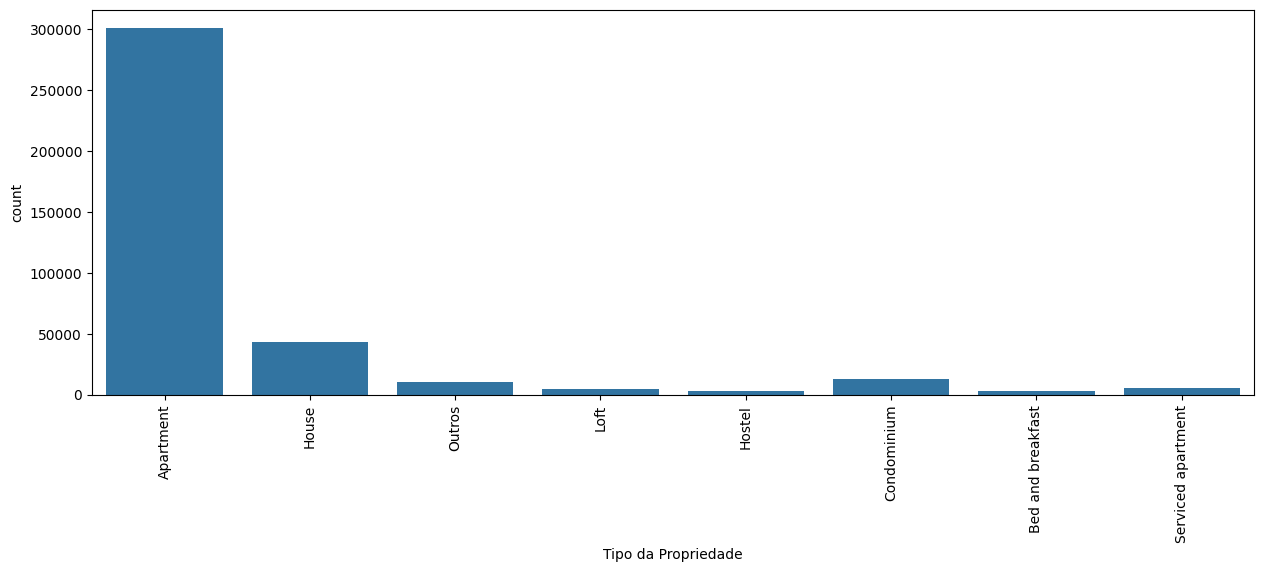

In [88]:
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base, x='Tipo da Propriedade')
grafico.tick_params(axis='x', rotation=90)

### Tipo do Quarto

Entire home/apt    270446
Private room        99986
Shared room         10469
Hotel room            588
Name: Tipo do Quarto, dtype: int64


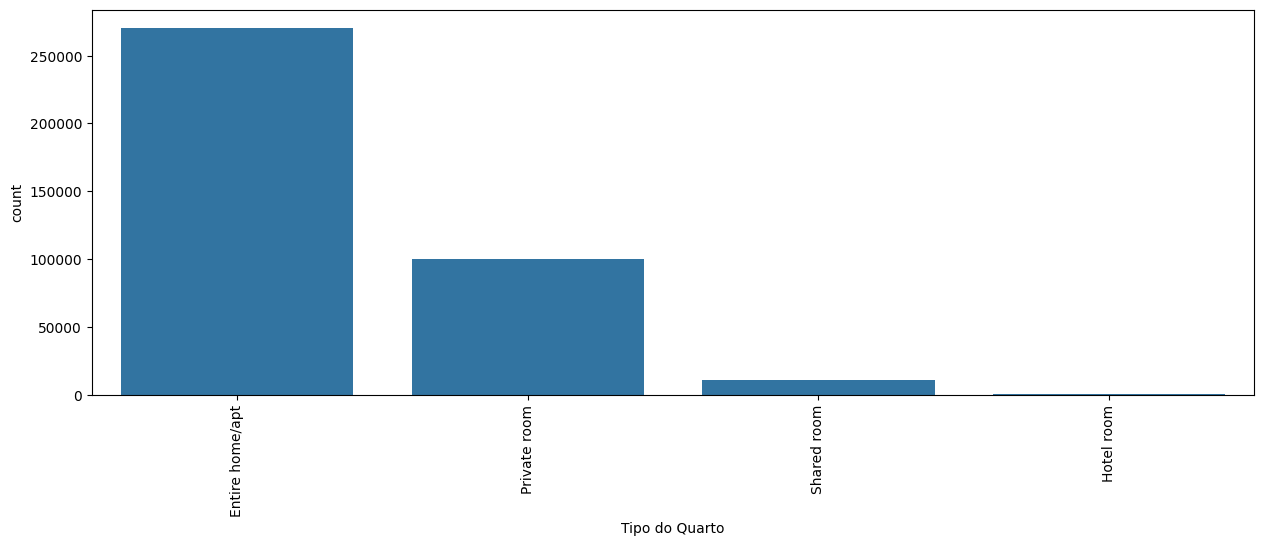

In [89]:
print(base['Tipo do Quarto'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base, x='Tipo do Quarto')
grafico.tick_params(axis='x', rotation=90)

- Por enquanto não farei nada em relação à essa Feature

Real Bed         375399
Pull-out Sofa      3969
Airbed              995
Futon               758
Couch               368
Name: Tipo da Cama, dtype: int64


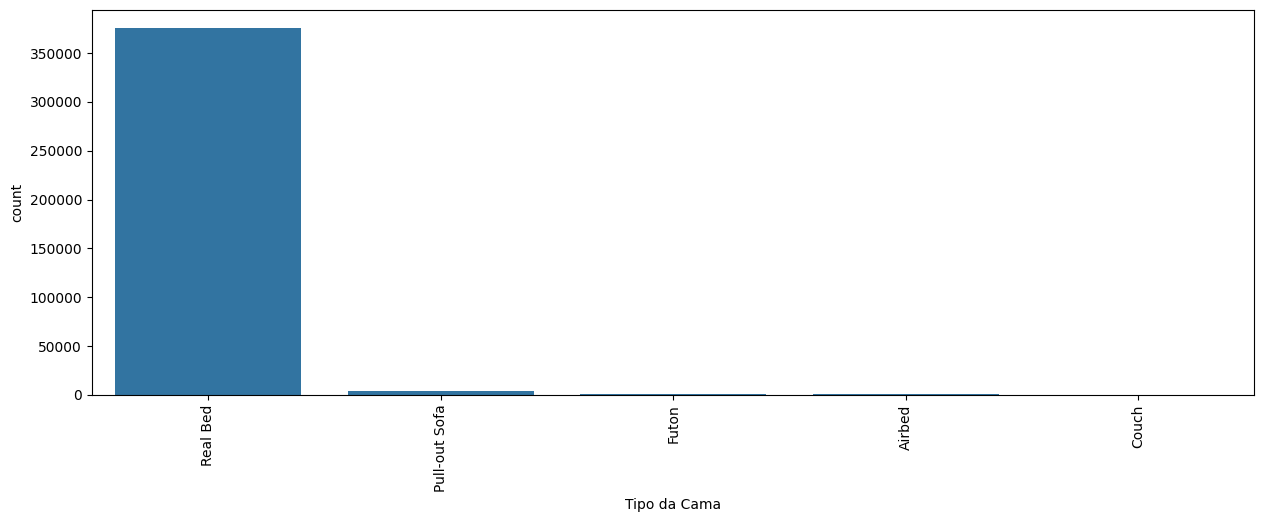

In [90]:
print(base['Tipo da Cama'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base, x='Tipo da Cama')
grafico.tick_params(axis='x', rotation=90)

In [91]:
tabela_tipos_cama = base['Tipo da Cama'].value_counts()
coluna_agurupar = []
for tipo in tabela_tipos_cama.index:
    if tabela_tipos_cama[tipo] < 20000:
        coluna_agurupar.append(tipo)
print(coluna_agurupar)

['Pull-out Sofa', 'Airbed', 'Futon', 'Couch']


In [92]:
for tipo in coluna_agurupar:
    base.loc[base['Tipo da Cama']==tipo, 'Tipo da Cama'] = 'Outros'

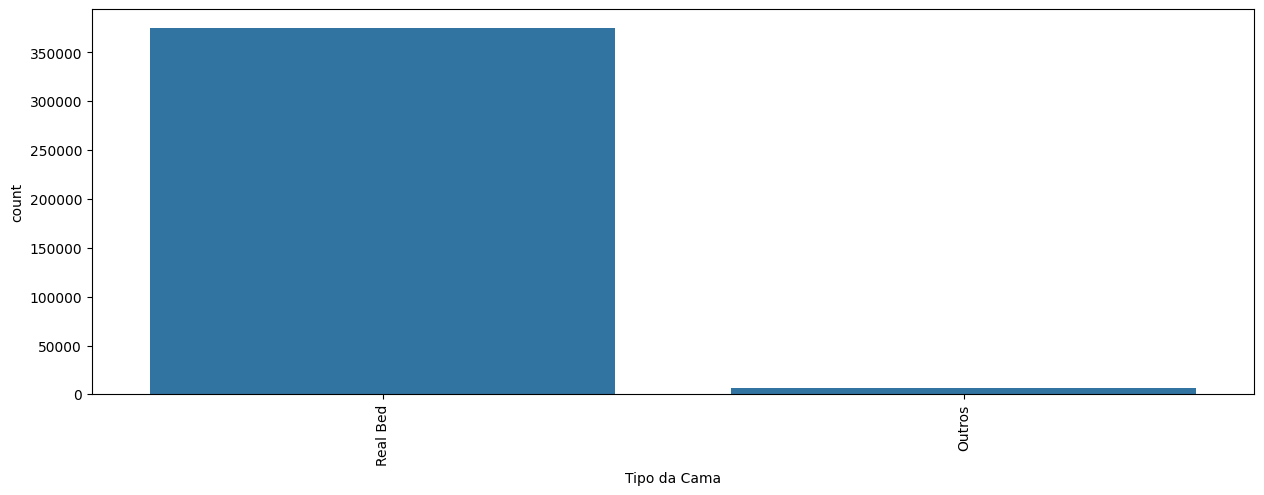

In [93]:
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base, x='Tipo da Cama')
grafico.tick_params(axis='x', rotation=90)

- No futuro podemos testar subamostragem e sobreamostragem para aumentar a quantidade de "outros"

### Reserva Instantânea

f    253651
t    127838
Name: Reserva Instantânea, dtype: int64


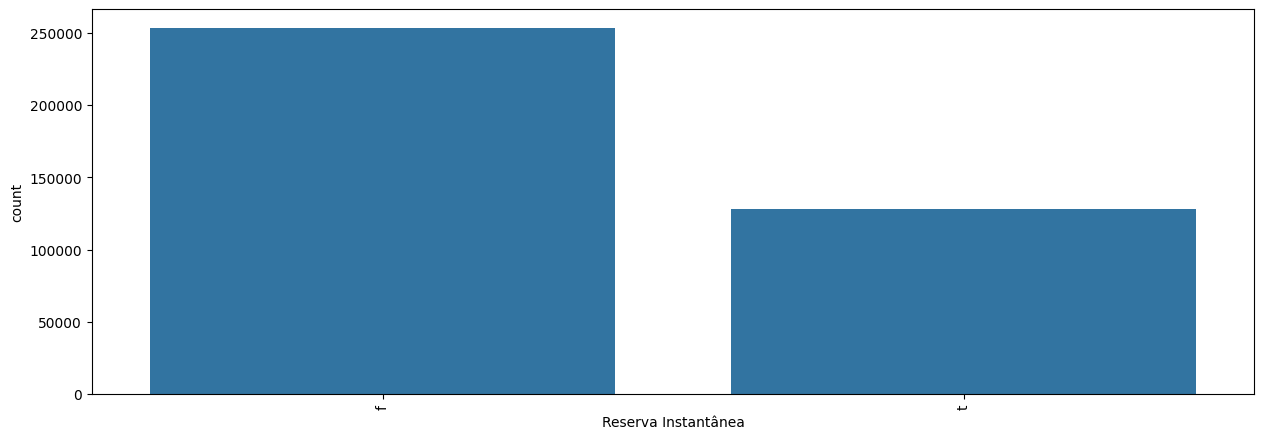

In [96]:
print(base['Reserva Instantânea'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base, x='Reserva Instantânea')
grafico.tick_params(axis='x', rotation=90)

- No futuro podemos testar subamostragem e sobreamostragem para aumentar a quantidade de "t"

### Política de Cancelamento

flexible                       223845
strict_14_with_grace_period    105087
moderate                        41660
strict                           5583
super_strict_60                  4122
super_strict_30                  1192
Name: Política de Cancelamento, dtype: int64


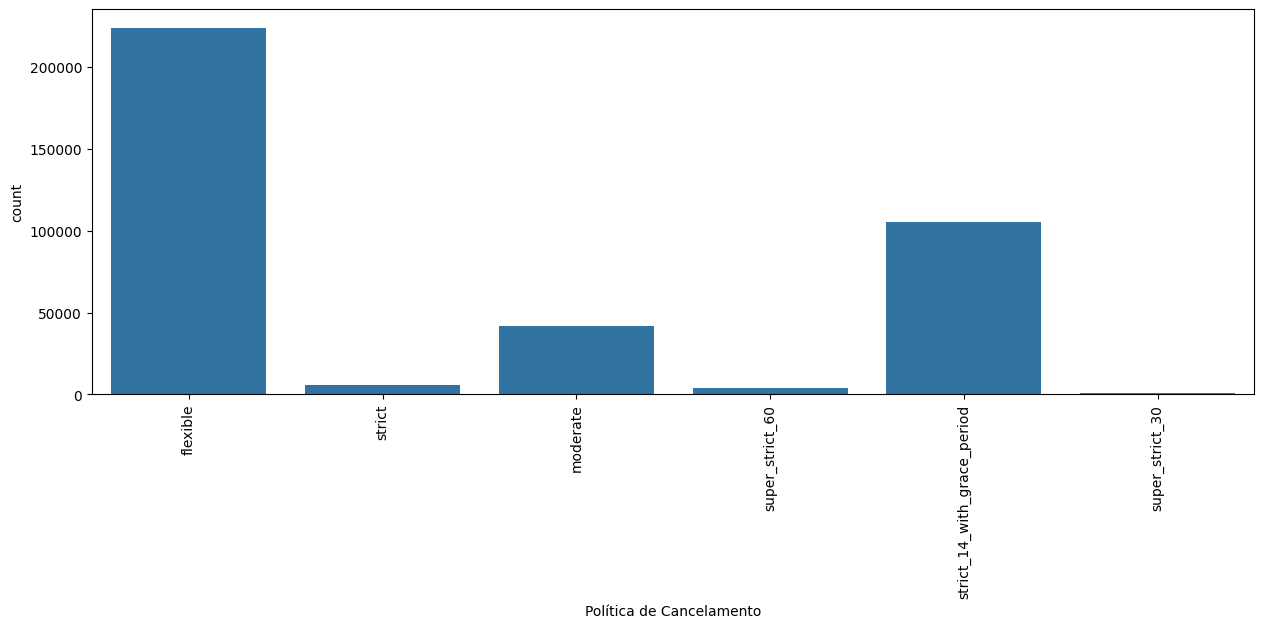

In [98]:
print(base['Política de Cancelamento'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base, x='Política de Cancelamento')
grafico.tick_params(axis='x', rotation=90)

In [99]:
tabela_tipos_politica = base['Política de Cancelamento'].value_counts()
coluna_agurupar = []
for tipo in tabela_tipos_politica.index:
    if tabela_tipos_politica[tipo] < 20000:
        coluna_agurupar.append(tipo)
print(coluna_agurupar)

['strict', 'super_strict_60', 'super_strict_30']


In [100]:
for tipo in coluna_agurupar:
    base.loc[base['Política de Cancelamento']==tipo, 'Política de Cancelamento'] = 'strict'

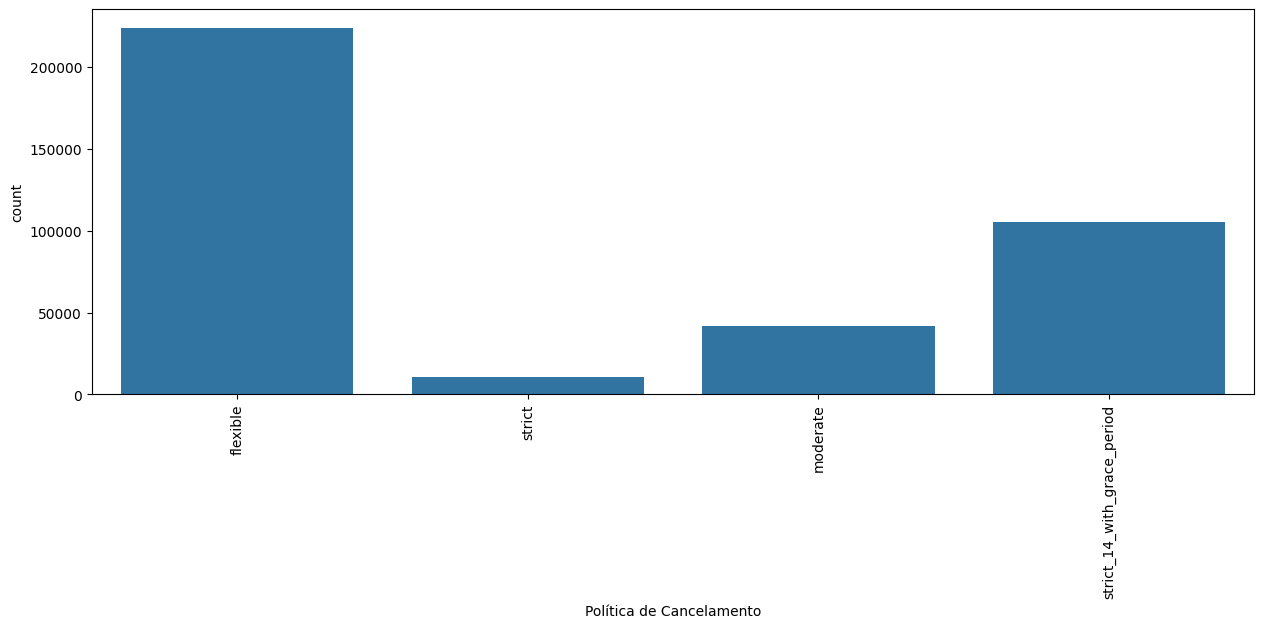

In [101]:
plt.figure(figsize=(15, 5))
grafico = sns.countplot(data=base, x='Política de Cancelamento')
grafico.tick_params(axis='x', rotation=90)

### Bônus

- Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [104]:
print(base['Bônus'].iloc[1].split(','))
print(len(base['Bônus'].iloc[1].split(',')))

base['Bônus'] = base['Bônus'].str.split(',').apply(len)

['"{TV', 'Internet', 'Wifi', 'Elevator', '""Family/kid friendly""', 'Washer}"']
6


In [106]:
base.shape

(381489, 22)

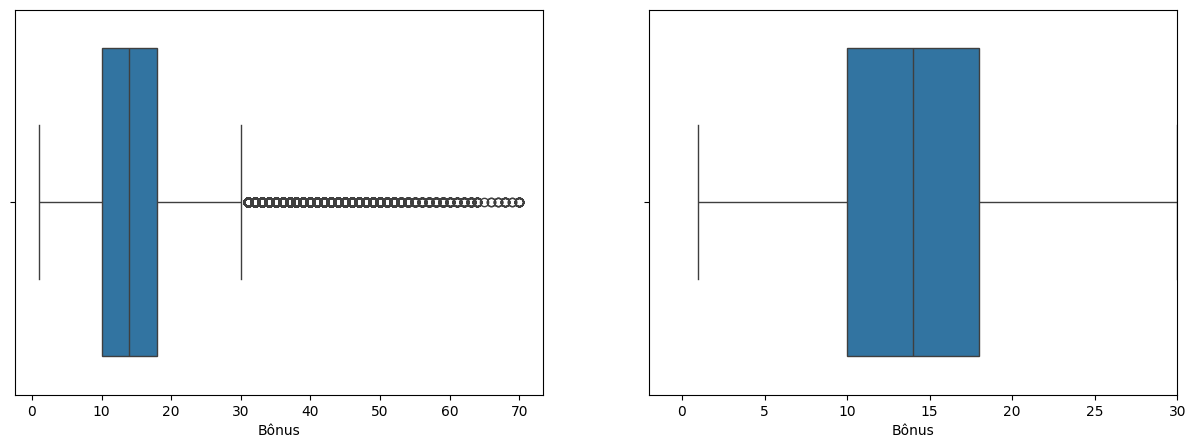

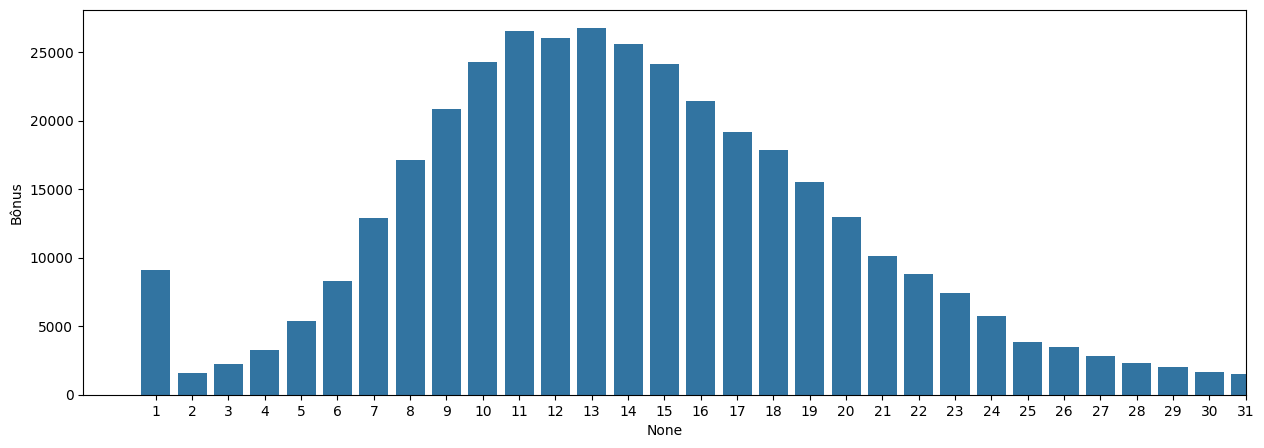

In [107]:
diagrama_caixa(base['Bônus'])
grafico_barra(base['Bônus'])

### Visualização de Mapa das Propriedades
- Vamos criar um mapa que exibe um pedaço da nossa base de dados aleatório (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço

In [122]:
amostra = base.sample(n=50000)
centro_mapa = {'lat':amostra.Latitude.mean(), 'lon':amostra.Longitude.mean()}
mapa = px.density_mapbox(amostra, lat='Latitude', lon='Longitude',z='Preço', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='open-street-map')
mapa.show()

### Encoding